# The Lahman Baseball Database - Data Wrangling and Exploration

Matthew Chana - March 27th 2017

### SUMMARY

##### The Lahman Baseball Database
The Lahman Baseball Database is a comprehensive record of batting and pitching statistics from 1871 to 2016. It also contains fielding statistics, standings, team stats, managerial records, post-season data, and a number of other data points.

##### Batting Average vs. General Measures of Success
In this investigation I will focus on a clear measure of performance - career batting average, which is arguably the most important statistic with respect to hitting in baseball. ** *Does career batting average correlate to general notions of success such as appearing in an All-Star game, garnering a high salary or winning awards?* ** One would expect so. 

Additionally, I will formulate a measure of success that I have never seen accounted for in baseball statistics but is of interest to me - how "adaptable" a player is. Here this will be understood to be the ability for a player to switch between fielding positions at any point in his career (the more evenly a player's record of appearances playing different positions, the higher the adaptability score). The Appearances table will allow me to aggregate the number of career appearances made by each player to create this measure.

The most relevant tables from The Lahman Baseball Database for the investigation are:

* Appearances - the number of offensive and defensive game appearances made by a player (Appearances.csv)
* Regular-season batting statistics (Batting.csv)
* All-Star appearances (AllstarFull.csv)
* Player salary (Salaries.csv)
* Awards received (AwardsPlayers.csv)

##### Players Considered for the Investigation
Batting average in baseball is an excellent measure of performance, but really only for players who are expected to hit at least fairly well. I will discard pitchers for this reason, and I will only consider players with 250 more games in which they have batted.

One interesting note - a player to look out for in many of these tables is Hank Aaron (playerID: aaronha01), who is one of the most regarded players in baseball history.

### DATA WRANGLING

##### Creating a List of Players Considered for the Investigation
In order to narrow my focus to players who were **not** pitchers and who participated in at least 250 with batting opportunities, I'll need to generate a list of players who fall into this category.

In [2]:
# import declarations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# displays all columns for each dataframe
pd.set_option('display.max_columns', None)

# displays 6 rows (top 3 and bottom 3) for each dataframe
pd.set_option('display.max_rows', 6)

In [3]:
# funciton to make loading tables easier
def load(data_file):
    return pd.read_csv('supporting-files/baseballdatabank-2017/core/' + data_file)

The Appearances table from the Lahman Baseball Database contains each player's number of appearances, including number of times played in each position and number of games in which the player batted, for each season since 1871. This is exactly what I need to narrow my focus appropriately.

In [4]:
# load the appearances table
appearances_full = load('Appearances.csv')
appearances_full

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,TRO,NaN,abercda01,1,NaN,1,1,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN
1,1871,RC1,NaN,addybo01,25,NaN,25,25,0,0,0,22,0,3,0,0,0,0,NaN,NaN,NaN
2,1871,CL1,NaN,allisar01,29,NaN,29,29,0,0,0,2,0,0,0,29,0,29,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102758,2016,CHN,NL,zobribe01,147,142.0,147,146,0,0,1,119,0,1,27,0,24,46,0.0,4.0,0.0
102759,2016,SEA,AL,zuninmi01,55,48.0,55,52,0,52,0,0,0,0,0,0,0,0,2.0,3.0,0.0
102760,2016,SEA,AL,zychto01,12,0.0,0,12,12,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0


Really what I need is career statistics. Grouping and summing by 'playerID' will achieve this.

In [5]:
# group and sum to find career appearances for each player based on unique playerID
career_appearances = appearances_full.groupby(appearances_full.playerID).sum()

# drop the yearID column
career_appearances = career_appearances.drop('yearID', axis=1)

career_appearances

,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
playerID,,,,,,,,,,,,,,,,,
aardsda01,331,0.0,139,331,331,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
aaronha01,3298,3173.0,3298,2985,0,0,210,43,7,0,315,308,2174,2760,201.0,122.0,1.0
aaronto01,437,206.0,437,346,0,0,232,7,10,0,135,1,2,137,0.0,102.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuverge01,266,31.0,266,265,265,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0
zwilldu01,366,310.0,366,339,0,0,3,0,0,0,0,334,4,338,0.0,24.0,1.0
zychto01,25,1.0,0,25,25,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0


The Appearances table doesn't define who is to be considered a pitcher, first baseman, left fielder, and so forth. It only records the number of games a player made an apperance. Let's consider a pitcher to be any player who made more than 90% of his appearances as a pitcher and encompass that logic into a function.

In [6]:
# function to determine who is NOT a pitcher based on a threshold
def is_not_pitcher(row):
    try: 
        ratio = float(row[4]) / sum(row[4:13])
    except:
        return False
    return ratio < 0.90

In [7]:
# create dataframe of players who are NOT pitchers
not_pitchers = career_appearances[career_appearances.apply(is_not_pitcher, axis=1)]
not_pitchers

,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
playerID,,,,,,,,,,,,,,,,,
aaronha01,3298,3173.0,3298,2985,0,0,210,43,7,0,315,308,2174,2760,201.0,122.0,1.0
aaronto01,437,206.0,437,346,0,0,232,7,10,0,135,1,2,137,0.0,102.0,35.0
abadan01,15,4.0,15,9,0,0,8,0,0,0,0,0,1,1,0.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zupofr01,16,1.0,16,13,0,13,0,0,0,0,0,0,0,0,0.0,5.0,0.0
zuvelpa01,209,138.0,209,197,0,0,0,55,14,133,0,0,0,0,3.0,14.0,9.0
zwilldu01,366,310.0,366,339,0,0,3,0,0,0,0,334,4,338,0.0,24.0,1.0


Now I can simply slice the dataframe into a new one containing players with 250 or more games with batting opportunities.

In [8]:
# narrow down to players batting 250 or more career games
players = not_pitchers[not_pitchers['G_batting'] > 249]
players

,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
playerID,,,,,,,,,,,,,,,,,
aaronha01,3298,3173.0,3298,2985,0,0,210,43,7,0,315,308,2174,2760,201.0,122.0,1.0
aaronto01,437,206.0,437,346,0,0,232,7,10,0,135,1,2,137,0.0,102.0,35.0
abbated01,855,NaN,855,855,0,0,0,419,20,388,0,2,1,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuninmi01,350,323.0,350,344,0,344,0,0,0,0,0,0,0,0,3.0,7.0,1.0
zupcibo01,319,198.0,319,285,0,0,1,0,2,0,100,112,96,282,11.0,25.0,34.0
zwilldu01,366,310.0,366,339,0,0,3,0,0,0,0,334,4,338,0.0,24.0,1.0


In [9]:
# create a list of players from the dataframe
players_list = list(players.index)

# preview the list
players_list[0:6]

['aaronha01', 'aaronto01', 'abbated01', 'abbeych01', 'abbotku01', 'abnersh01']

I'm now left with 4,191 players who meet my criteria for the investigation.

##### Prepare Relevant Dataframes for Analysis
Now the maximum pool of players that I can consdier, I can apply it to each relevant table after I shape them and create at least one aggregation method for each:

##### Regular-season batting statistics (Batting.csv):
This regular-season batting table is comprehensive, so I should end up with the same number of players that are found in my list of players from above. I'll be grouping and summing to find career statistics for each player, and calculating lifetime batting average, which is simply lifetime hits divided by lifetime at-bats.

In [10]:
# load original batting table
batting = load('Batting.csv')

# group by playerID and sum to find career statistics for each player 
batting_career = batting.groupby(batting.playerID).sum()

# drop the yearID column
batting_career = batting_career.drop('yearID',axis=1)

# calculate career batting average
batting_career['lifetime_BA'] = round((batting_career['H']/batting_career['AB']),4)

# remove players who never batted (NaN)
batting_career.dropna(subset=['lifetime_BA'], inplace=True)

batting_career

,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,lifetime_BA
playerID,,,,,,,,,,,,,,,,,,,
aardsda01,9,331,4,0,0,0,0,0,0.0,0.0,0.0,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0000
aaronha01,23,3298,12364,2174,3771,624,98,755,2297.0,240.0,73.0,1402,1383.0,293.0,32.0,21.0,121.0,328.0,0.3050
aaronto01,7,437,944,102,216,42,6,13,94.0,9.0,8.0,86,145.0,3.0,0.0,9.0,6.0,36.0,0.2288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuvelpa01,9,209,491,41,109,17,2,2,20.0,2.0,0.0,34,50.0,1.0,2.0,18.0,0.0,8.0,0.2220
zuverge01,12,266,142,5,21,2,1,0,7.0,0.0,1.0,9,39.0,0.0,0.0,16.0,0.0,3.0,0.1479
zwilldu01,4,366,1280,167,364,76,15,30,202.0,46.0,NaN,128,139.0,NaN,4.0,31.0,NaN,NaN,0.2844


Looking at the right-most column of the above table, notice Hank Aaron (aaronha01) has a very respectable lifetime batting average of 0.305 while the player just above him (aardsda01) has a lifetime batting average of 0.0. Any player with such a low batting average has likely not had much experience batting, or doesn't bat at all (like some pitchers) and will need to be removed. I can create a function using the players list to focus in on only the players who meet my criteria of not being a pitcher and having at least 250 games batting.

In [11]:
# function returns True if a playerID from any given dataframe is in the players_list
def remove_from_df(id):
    return id in players_list

In [12]:
# apply function to remove any player who is NOT in the players_list
batting_career = batting_career[batting_career.index.map(remove_from_df)]

batting_career

,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,lifetime_BA
playerID,,,,,,,,,,,,,,,,,,,
aaronha01,23,3298,12364,2174,3771,624,98,755,2297.0,240.0,73.0,1402,1383.0,293.0,32.0,21.0,121.0,328.0,0.3050
aaronto01,7,437,944,102,216,42,6,13,94.0,9.0,8.0,86,145.0,3.0,0.0,9.0,6.0,36.0,0.2288
abbated01,11,855,3044,355,772,99,43,11,324.0,142.0,NaN,289,16.0,NaN,33.0,93.0,NaN,NaN,0.2536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuninmi01,4,350,1125,117,219,43,2,50,133.0,1.0,4.0,75,404.0,1.0,31.0,8.0,8.0,23.0,0.1947
zupcibo01,6,319,795,99,199,47,4,7,80.0,7.0,5.0,57,137.0,3.0,6.0,20.0,8.0,15.0,0.2503
zwilldu01,4,366,1280,167,364,76,15,30,202.0,46.0,NaN,128,139.0,NaN,4.0,31.0,NaN,NaN,0.2844


Sure enough, I have the same number of rows as there are players in the players list.

##### All-Star appearances (AllstarFull.csv):
What is an appropriate measure of All-Star appearances other than just calculating the total number of times a player was sent to the All-Star game? One method may simply be to find the ratio of the number of All-Star appearances to the number of years a player played. To find this I will first use the Master table (Master.csv) from the Lahman Baseball Database to compute the number of years in each player career:

In [13]:
# load master table
master = load('Master.csv')

# COMPUTE NUMBER OF YEARS PLAYED
# convert debut and finalGame columns to timestamps
master['debut'] = pd.to_datetime(master['debut'])
master['finalGame'] = pd.to_datetime(master['finalGame'])

# some rows don't have data - remove them
master.dropna(subset=['debut'], inplace=True)
master.dropna(subset=['finalGame'], inplace=True)

# calculate and add column for difference between debut and final game played
master['career-years'] =  master['finalGame'] - master['debut']

# converts days to years
master['career-years'] = master['career-years'].apply(lambda x: x.days / 365)

# group by playerID
master = master.groupby(master.playerID).first()

# remove any row with player career less than 2 years
# master = master[master['career-years'] > 2]

master

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,career-years
playerID,,,,,,,,,,,,,,,,,,,,,,,,,
aardsda01,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,NaN,NaN,NaN,David,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01,11.386301
aaronha01,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,NaN,NaN,NaN,Hank,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01,22.490411
aaronto01,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,USA,GA,Atlanta,Tommie,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01,9.468493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuverge01,zuverge01,1924.0,8.0,20.0,USA,MI,Holland,2014.0,9.0,8.0,USA,AZ,Tempe,George,Zuverink,George,195.0,76.0,R,R,1951-04-21,1959-06-15,zuveg101,zuverge01,8.156164
zwilldu01,zwilldu01,1888.0,11.0,2.0,USA,MO,St. Louis,1978.0,3.0,27.0,USA,CA,La Crescenta,Dutch,Zwilling,Edward Harrison,160.0,66.0,L,L,1910-08-14,1916-07-12,zwild101,zwilldu01,5.915068
zychto01,zychto01,1990.0,8.0,7.0,USA,IL,Monee,NaN,NaN,NaN,NaN,NaN,NaN,Tony,Zych,Anthony Aaron,190.0,75.0,R,R,2015-09-04,2016-08-24,zycht001,zychto01,0.972603


Now that there is a column for the length of each player's career, I can use it to calculate their average All-Star appearances:

In [14]:
# load original all-star appearances table
all_star = load('AllstarFull.csv')

# count number of times player was sent to all-star game(s)
all_star['sent_to_AS'] = 1

# group by playerID and compute career all-star appearances
all_star_career = all_star.groupby(all_star.playerID).sum()

# drop unecessary columns (yearID, gameNum and startingPos)
all_star_career = all_star_career.drop(['yearID','gameNum','startingPos'],axis=1)

# concatenate this dataframe with career-years from master dataframe
all_star_career = pd.concat([all_star_career, master['career-years']], axis=1)

# remove any row with NaN for sent_to_AS (player never went to All-Star game)
all_star_career.dropna(subset=['sent_to_AS'], inplace=True)

# calculate all-star appearances average
all_star_career['avg-all-star-appearances'] = all_star_career['sent_to_AS'] / all_star_career['career-years']

# remove any player who is NOT in the players_list
all_star_career = all_star_career[all_star_career.index.map(remove_from_df)]

all_star_career

,GP,sent_to_AS,career-years,avg-all-star-appearances
aaronha01,24.0,25.0,22.490411,1.111585
abreubo01,2.0,2.0,18.084932,0.110589
abreujo02,1.0,1.0,2.509589,0.398472
...,...,...,...,...
zimmery01,1.0,1.0,11.093151,0.090146
ziskri01,2.0,2.0,12.043836,0.166060
zobribe01,2.0,3.0,10.178082,0.294751


This leaves me with a much more focused pool of players who are not pitchers and who have batted more than 250 games, who's career career average for All-Star appearances we can use for the investigation. Note, a player's career average All-Star appearances may be greater than 1 for players (Hank Aaron for example). This is because at periods in the 50's and 60's [more than one all star game was played](http://www.nytimes.com/2008/07/15/sports/baseball/15sandomir.html).

##### Player salary (Salaries.csv):
Now on to player salary. A player's salary in 1985(the year records for salary began) dollars is not what it would be in 2016 dollars, so I've adjusted for inflation using the [United States Bureau of Labor Statistics' Consumer Price Index](https://www.bls.gov/data/) historical data (each year adjusted independently and then the average taken of all a player's salaries over the course of a baseball career). I captured this data and then adjusted each salary to the 2016 annual average (2017 doesn't yet have a year-end average. I then average the salary across a player's career.

In [15]:
# load the salaries and cpi(Consumer Price Index) dataframes
salaries = load('Salaries.csv')
cpi = load('consumer_price_index.csv')

# function queries the cpi dataframe to find a value corresponding to the year x
def cpi_val(x):
    return float(cpi.loc[cpi['Year'] == x, 'Annual-Avg'].values[0])

# formula computes/creates new column for avergage adjusted salary
# note, 240.007 here is the 2016 year-end average.
salaries['avg-adjusted'] = (240.007 * salaries['salary']) / salaries['yearID'].apply(cpi_val)

# supress scientific notation in the dataframe
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# COMPUTE AVERAGE SALARY OVER THE COURSE OF A PLAYER'S CAREER
# group by playerID and find the average
salaries_career = salaries.groupby(salaries.playerID).mean()
# drop yearID column
salaries_career = salaries_career.drop('yearID', axis=1)
# rename column to 'avg-salar-adj'
salaries_career.columns = ['avg-salary', 'avg-career-salary']

# remove any player who is NOT in the players_list
salaries_career = salaries_career[salaries_career.index.map(remove_from_df)]

salaries_career

,avg-salary,avg-career-salary
playerID,,
abbotku01,470778,686487
abnersh01,144700,259552
abreubo01,7773729,9231062
...,...,...
zobribe01,4169510,4278451
zuninmi01,513800,520585
zupcibo01,143667,243803


Again, this appropriately narrows in on players who both meet the criteria for investigation and who have a recorded salary that is now adjusted for inflation.

##### Awards received (AwardsPlayers.csv):
Similarly to the All-Star apperances table, the average awards received per year as a ratio between the number of awards received and the number of years a player played will be calcualted here:

In [16]:
# load original awards dataframe
awards_players = load('AwardsPlayers.csv')

# tally up total awards
awards_players['awarded'] = 1

# group by awards received over course of career
awards_players_career = awards_players.groupby(awards_players.playerID).sum()

# drop yearID
awards_players_career = awards_players_career.drop('yearID', axis=1)

# COMPUTE THE AVERAGE NUMBER OF AWARDS WON OVER THE COURSE OF A PLAYER'S CAREER
# concatenate this dataframe with career-years from master dataframe
awards_players_career = pd.concat([awards_players_career, master['career-years']], axis=1)

# undo supress scientific notation
pd.set_option('display.float_format', None)

# remove any row with NaN (artifact of concatenating)
awards_players_career.dropna(inplace=True)

# calculate all-star appearances average
awards_players_career['avgerage-awards'] = awards_players_career['awarded'] / awards_players_career['career-years']

# remove any player who is NOT in the players_list
awards_players_career = awards_players_career[awards_players_career.index.map(remove_from_df)]

awards_players_career

,awarded,career-years,avgerage-awards
aaronha01,16.0,22.490411,0.711414
abreubo01,2.0,18.084932,0.110589
abreujo02,2.0,2.509589,0.796943
...,...,...,...
zimmery01,4.0,11.093151,0.360583
ziskri01,2.0,12.043836,0.166060
zobribe01,1.0,10.178082,0.098250


Glancing again at Hank Aaron (aaronha01), his average awards wond over the course of his career is not as high as player abreujo02 just below, but the fact that he maintained such a high average over such a long career is pretty amazing.

Moving on, this is enough data wrangling to start visualizing the initial investigation to see how lifetime batting average correlates to the various measures of success.

### DATA EXPLORATION
As mentioned, I'm going to mainly be looking for correlations between lifetime batting average and three variables measuring success - awards received, All-Star appearances and salary.

Before doing this I want to first see how each of my variables as aggregated for the investigation are distributed:

In [17]:
# all of the aggregated variables
lifetime_BA = batting_career['lifetime_BA']
avg_awards = awards_players_career['avgerage-awards']
avg_all_star = all_star_career['avg-all-star-appearances']
avg_salary_adj = salaries_career['avg-career-salary']

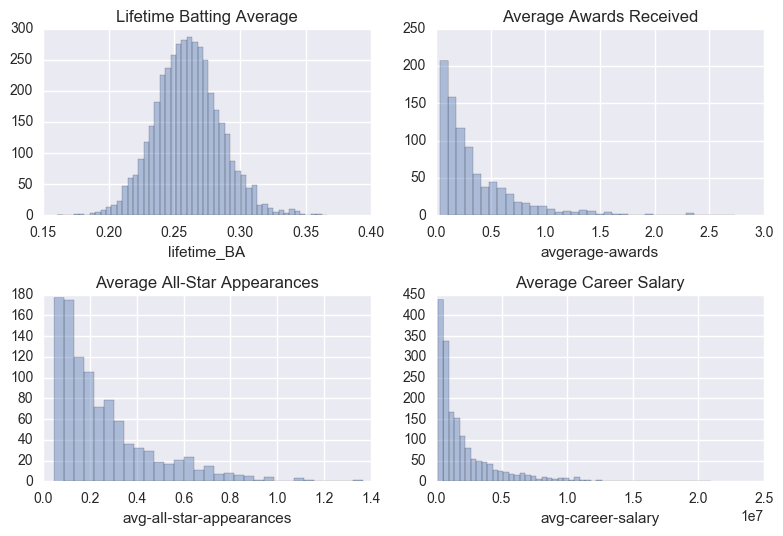

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=False)
sns.distplot(lifetime_BA, ax=ax1, kde=False)
sns.distplot(avg_awards, ax=ax2, kde=False)
sns.distplot(avg_all_star, ax=ax3, kde=False)
sns.distplot(avg_salary_adj, ax=ax4, kde=False)
ax1.set_title('Lifetime Batting Average')
ax2.set_title('Average Awards Received')
ax3.set_title('Average All-Star Appearances')
ax4.set_title('Average Career Salary')
plt.tight_layout()
plt.show()

Lifetime batting average seems to be pretty normally distributed. This doesn't surprise me given it is a measure of physical ability. I'm also not surprised at the distribution of the measures of success. For each of them (average awards, average all-star appearances, and average salary), higher numbers on the x-axis are more rare - so a larger amount of players for each fall into the more common lower scores to the left side of the distribution. So each of them are positively skewed as one would expect from a measure of success.

That is interesting, but it doesn't change my search for correlations between lifetime batting average and the measures of success:

##### Lifetime batting average vs. average awards received:

To plot lifetime batting average against average awards received I'll unify the data from two different dataframes:

In [19]:
# create a new dataframe containing the two sets to plot
awards_ba = pd.concat([awards_players_career, batting_career['lifetime_BA']], axis=1)
awards_ba.dropna(inplace=True)
awards_ba

,awarded,career-years,avgerage-awards,lifetime_BA
aaronha01,16.0,22.490411,0.711414,0.3050
abreubo01,2.0,18.084932,0.110589,0.2913
abreujo02,2.0,2.509589,0.796943,0.2995
...,...,...,...,...
zimmery01,4.0,11.093151,0.360583,0.2779
ziskri01,2.0,12.043836,0.166060,0.2871
zobribe01,1.0,10.178082,0.098250,0.2659


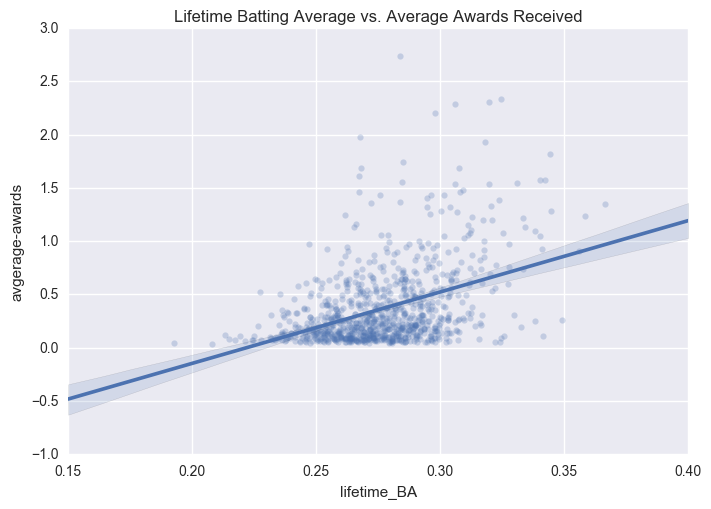

In [21]:
# plotting function for scatter plot
ax = sns.regplot(x='lifetime_BA', y='avgerage-awards', data=awards_ba, scatter_kws={'alpha':0.25})
ax.set_title('Lifetime Batting Average vs. Average Awards Received')
plt.show()

The scatter plot with regression line plotted appear to show a correlation between lifetime batting average and average awards received over the course of a player's career, as expected. But what is the correlation quantified?

In [22]:
# pearson's r function for lifetime batting average vs. awards
awards_ba[['lifetime_BA','avgerage-awards']].corr()

,lifetime_BA,avgerage-awards
lifetime_BA,1.000000,0.420179
avgerage-awards,0.420179,1.000000


A Pearson's correlation score of approximately 0.42 reveals a moderate positive correlation between the variables.

##### Lifetime batting average vs. average All-Star appearances:
Now on to All-Star appearances. I would expect this to have a similar correlation to lifetime batting average:

In [23]:
# create a new dataframe containing the two sets to plot
all_star_ba = pd.concat([all_star_career, batting_career['lifetime_BA']], axis=1)
all_star_ba.dropna(inplace=True)
all_star_ba

,GP,sent_to_AS,career-years,avg-all-star-appearances,lifetime_BA
aaronha01,24.0,25.0,22.490411,1.111585,0.3050
abreubo01,2.0,2.0,18.084932,0.110589,0.2913
abreujo02,1.0,1.0,2.509589,0.398472,0.2995
...,...,...,...,...,...
zimmery01,1.0,1.0,11.093151,0.090146,0.2779
ziskri01,2.0,2.0,12.043836,0.166060,0.2871
zobribe01,2.0,3.0,10.178082,0.294751,0.2659


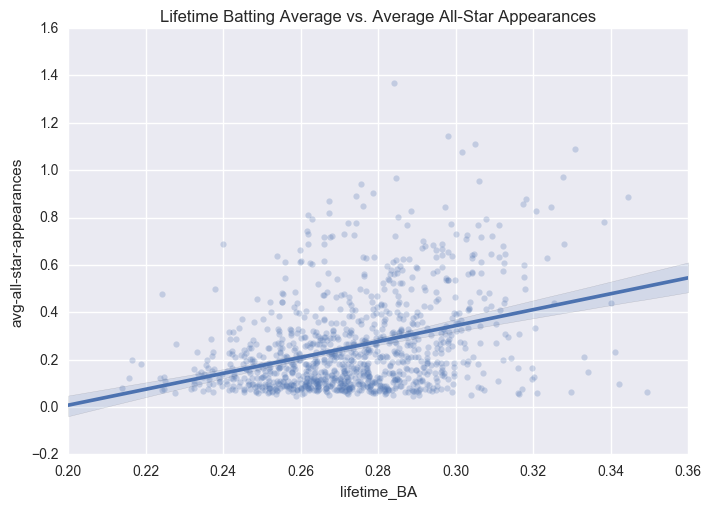

In [24]:
# plotting function
ax = sns.regplot(x='lifetime_BA', y='avg-all-star-appearances', data=all_star_ba, scatter_kws={'alpha':0.25})
ax.set_title('Lifetime Batting Average vs. Average All-Star Appearances')
plt.show()

Again, as expected there seems to be a correlation between lifetime batting average and the average All-Star appearances for a given player. One interesting side note from looking at the plot is that Hank Aaron, along with only four other players seem to have averaged more than one All-Star game over the course of their career.

In [44]:
all_star_ba[['lifetime_BA','avg-all-star-appearances']].corr()

,lifetime_BA,avg-all-star-appearances
lifetime_BA,1.000000,0.347765
avg-all-star-appearances,0.347765,1.000000


It's on the lower end of a moderate positive correlation but there still seems to be a correlation to speak of.

##### Lifetime batting average vs. career average salary:
Finally, I will look at lifetime batting average vs. career average salary:

In [45]:
# create a new dataframe containing the two sets to plot
salary_ba = pd.concat([salaries_career, batting_career['lifetime_BA']], axis=1)
salary_ba.dropna(inplace=True)
salary_ba

,avg-salary,avg-career-salary,lifetime_BA
abbotku01,4.707778e+05,6.864872e+05,0.2559
abnersh01,1.447000e+05,2.595522e+05,0.2274
abreubo01,7.773729e+06,9.231062e+06,0.2913
...,...,...,...
zobribe01,4.169510e+06,4.278451e+06,0.2659
zuninmi01,5.138000e+05,5.205846e+05,0.1947
zupcibo01,1.436667e+05,2.438034e+05,0.2503


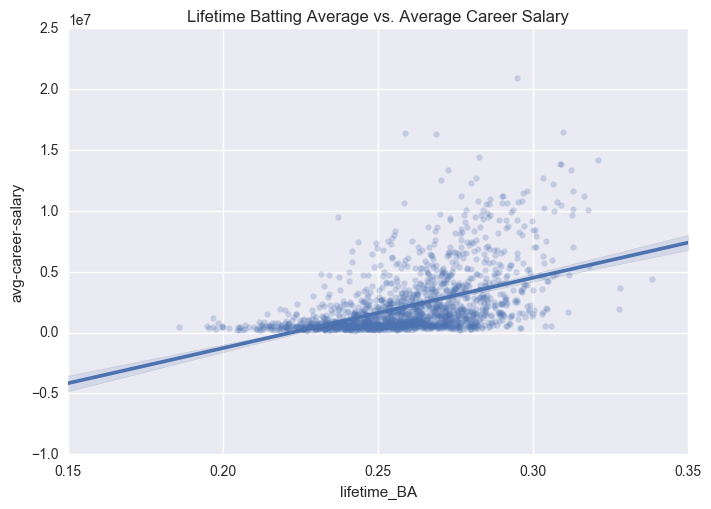

In [46]:
# plotting function
ax = sns.regplot(x='lifetime_BA', y='avg-career-salary', data=salary_ba, scatter_kws={'alpha':0.25})
ax.set_title('Lifetime Batting Average vs. Average Career Salary')
plt.show()

I'm happy to see a stronger correlation here, mainly because batting average is an extremely important statistic in hitting. I would hope players with a higher batting average were rewarded with a higher salary, and indeed they are.

In [47]:
salary_ba[['lifetime_BA','avg-career-salary']].corr()

,lifetime_BA,avg-career-salary
lifetime_BA,1.000000,0.493643
avg-career-salary,0.493643,1.000000


The Pearson's correlation here is a solid moderate correlation.

### Analysis of Player Adaptability
Lifetime batting average in the above investigation was an easy to identify measure of performance. Calculating it and then comparing it to variables representing measures of success played out without any twists in what one's intuition would be for a measure of performance's correlation to measures of success. But what other statistic might exist that is not obvious or traditionally the focus of baseball analytics?

One thing that interests me is to know how 'adaptable' a player is in field positions. For example, a player may be a catcher at one point in his career and then switch to being a second baseman. Or perhaps a player alternates between second and thrid base throughout the season. Looking at the below 'players' table reveals that this does happen. Hank Aaron (aaronha01) is among them for example, and in fact all but one of the players in the below table show that moving between positions at some point over the course of a career is common in baseball. The positions played over the course of a career can be seen in the following columns:

* G_p:            Games as pitcher
* G_c:            Games as catcher
* G_1b:           Games as firstbaseman
* G_2b:           Games as secondbaseman
* G_3b:           Games as thirdbaseman
* G_ss:           Games as shortstop
* G_lf:           Games as leftfielder
* G_cf:           Games as centerfielder
* G_rf:           Games as right fielder

In [48]:
players

,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,adaptability_score
playerID,,,,,,,,,,,,,,,,,,
aaronha01,3298,3173.0,3298,2985,0,0,210,43,7,0,315,308,2174,2760,201.0,122.0,1.0,1.0550
aaronto01,437,206.0,437,346,0,0,232,7,10,0,135,1,2,137,0.0,102.0,35.0,1.1727
abbated01,855,NaN,855,855,0,0,0,419,20,388,0,2,1,3,NaN,NaN,NaN,1.1929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuninmi01,350,323.0,350,344,0,344,0,0,0,0,0,0,0,0,3.0,7.0,1.0,0.1716
zupcibo01,319,198.0,319,285,0,0,1,0,2,0,100,112,96,282,11.0,25.0,34.0,1.6015
zwilldu01,366,310.0,366,339,0,0,3,0,0,0,0,334,4,338,0.0,24.0,1.0,0.2366


##### Calculate player adaptability score:
For each player's set of appearances, I will create a 'player adaptability score' which is calculated by looking at the possible field-positions in baseball (again excluding pitchers). 

For each player's total appearances, the formula will be three minus the standard deviation divided by the mean.

$$\text{Player Position Adaptability } = 3-\frac{\sigma}{\bar{x}}$$

This formula seems rather arbitrary, but there are reasons for it. Firstly, a player's career can have fully played out, or they be just have started building the momentum of their career. So I knew the goal was to deal in terms of relative measures such as mean and standard deviation for each player's appearances, both of which hinge upon the number of measurements (in this case the total number of appearances the player made). In creating the formula, some of my test-cases were to:

* clump the appearances together into a single position
* spread the appearances evenly across all positions
* spread the appearances evenly against half of the positions

Taking the mean for each player's appearances itself didn't mediate the length of a player's career. So I took the standard deviation across all the players and scanned through it. This pretty much brought me to a way of standardizing a player's adaptability. Keeping in mind that the standard deviation was usually around a third of the mean, my last step was to simply subtract the number three in order to leave me with a number closer to zero as the lower bound and around 1 as the upper bound.

To apply the formula, I will piggy-back on the players table from the data wrangling phase of the investigation to compute the player adaptability score:

In [49]:
# list of the relevant positions
positions = ['G_p','G_c','G_1b','G_2b','G_3b','G_ss','G_lf','G_cf','G_rf']

# house-keeping setting to supress a warning from the pandas package
players.is_copy = False

# vector operation to compute the player adaptability score for each player
players['adaptability_score'] = 3 - round((players.loc[:,positions].std(axis=1, ddof=0)/players.loc[:,positions].mean(axis=1)),4)
players

,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,adaptability_score
playerID,,,,,,,,,,,,,,,,,,
aaronha01,3298,3173.0,3298,2985,0,0,210,43,7,0,315,308,2174,2760,201.0,122.0,1.0,1.0550
aaronto01,437,206.0,437,346,0,0,232,7,10,0,135,1,2,137,0.0,102.0,35.0,1.1727
abbated01,855,NaN,855,855,0,0,0,419,20,388,0,2,1,3,NaN,NaN,NaN,1.1929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuninmi01,350,323.0,350,344,0,344,0,0,0,0,0,0,0,0,3.0,7.0,1.0,0.1716
zupcibo01,319,198.0,319,285,0,0,1,0,2,0,100,112,96,282,11.0,25.0,34.0,1.6015
zwilldu01,366,310.0,366,339,0,0,3,0,0,0,0,334,4,338,0.0,24.0,1.0,0.2366


Now I can simply repeat my same process from the above plots, except this time with player adaptability score against our three measures of success:

##### Player adaptability score vs. awards received:

In [50]:
awards_as = pd.concat([awards_players_career, players['adaptability_score']], axis=1)
awards_as.dropna(inplace=True)
awards_as

,awarded,career-years,avgerage-awards,adaptability_score
aaronha01,16.0,22.490411,0.711414,1.0550
abreubo01,2.0,18.084932,0.110589,0.4060
abreujo02,2.0,2.509589,0.796943,0.1716
...,...,...,...,...
zimmery01,4.0,11.093151,0.360583,0.6955
ziskri01,2.0,12.043836,0.166060,1.1182
zobribe01,1.0,10.178082,0.098250,1.6274


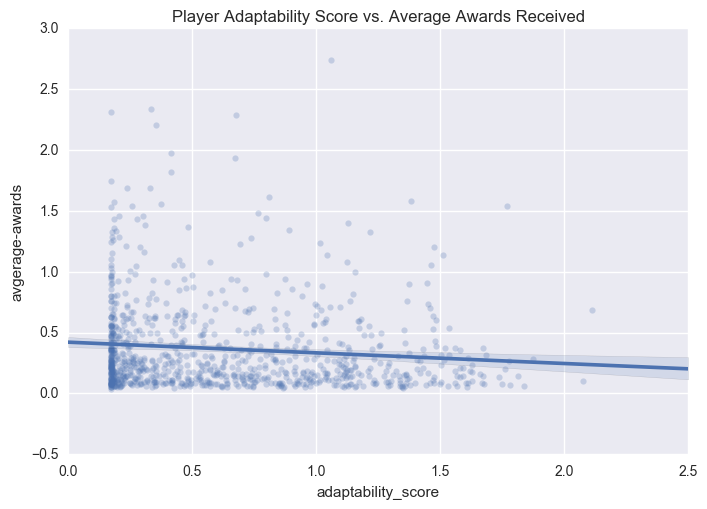

In [51]:
ax = sns.regplot(x='adaptability_score', y='avgerage-awards', data=awards_as, scatter_kws={'alpha':0.25})
ax.set_title('Player Adaptability Score vs. Average Awards Received')
plt.show()

In [34]:
awards_as[['adaptability_score','avgerage-awards']].corr()

,adaptability_score,avgerage-awards
adaptability_score,1.000000,-0.106252
avgerage-awards,-0.106252,1.000000


If there is a correlation between player adaptability score and average awards, it's a very weak one. The Pearson's r at approximately -0.106 confirms this as a very weak negative correlation.

##### Player adaptability score vs. All-Star appearacnes:

In [52]:
all_star_as = pd.concat([all_star_career, players['adaptability_score']], axis=1)
all_star_as.dropna(inplace=True)
all_star_as

,GP,sent_to_AS,career-years,avg-all-star-appearances,adaptability_score
aaronha01,24.0,25.0,22.490411,1.111585,1.0550
abreubo01,2.0,2.0,18.084932,0.110589,0.4060
abreujo02,1.0,1.0,2.509589,0.398472,0.1716
...,...,...,...,...,...
zimmery01,1.0,1.0,11.093151,0.090146,0.6955
ziskri01,2.0,2.0,12.043836,0.166060,1.1182
zobribe01,2.0,3.0,10.178082,0.294751,1.6274


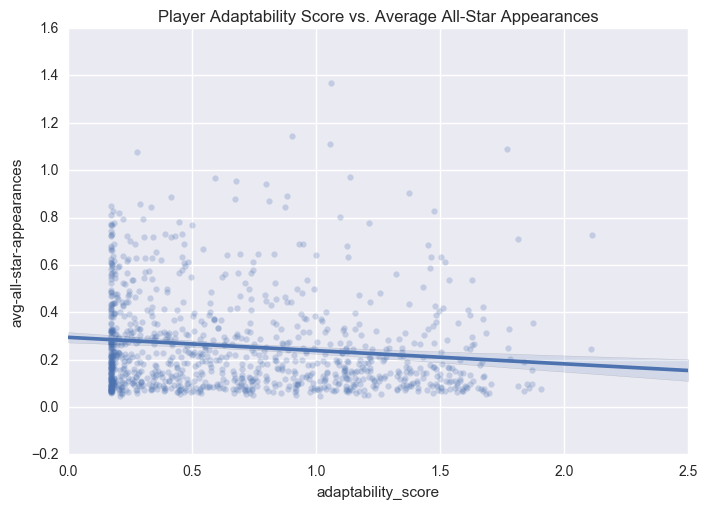

In [54]:
ax = sns.regplot(x='adaptability_score', y='avg-all-star-appearances', data=all_star_as, scatter_kws={'alpha':0.25})
ax.set_title('Player Adaptability Score vs. Average All-Star Appearances')
plt.show()

In [37]:
all_star_as[['adaptability_score','avg-all-star-appearances']].corr()

,adaptability_score,avg-all-star-appearances
adaptability_score,1.00000,-0.13501
avg-all-star-appearances,-0.13501,1.00000


Likewise, with player adaptability score plotted agaist the average All-Star appearances, there is a very weak correlation, but very slightly stronger than the the awards received plot above. Hank Aaron, with an adaptability score of just short of 1.0 on the x-axis and average All-Star appearances of around 1.1, seems to be one of the contributing examples to this weak correlation as a stronger correlation would likely place him on either end of adaptability score or average All-Star rating. 

##### Player adaptability score vs. career salary average:

In [55]:
salary_as = pd.concat([salaries_career, players['adaptability_score']], axis=1)
salary_as.dropna(inplace=True)
salary_as

,avg-salary,avg-career-salary,adaptability_score
abbotku01,4.707778e+05,6.864872e+05,1.3695
abnersh01,1.447000e+05,2.595522e+05,1.5023
abreubo01,7.773729e+06,9.231062e+06,0.4060
...,...,...,...
zobribe01,4.169510e+06,4.278451e+06,1.6274
zuninmi01,5.138000e+05,5.205846e+05,0.1716
zupcibo01,1.436667e+05,2.438034e+05,1.6015


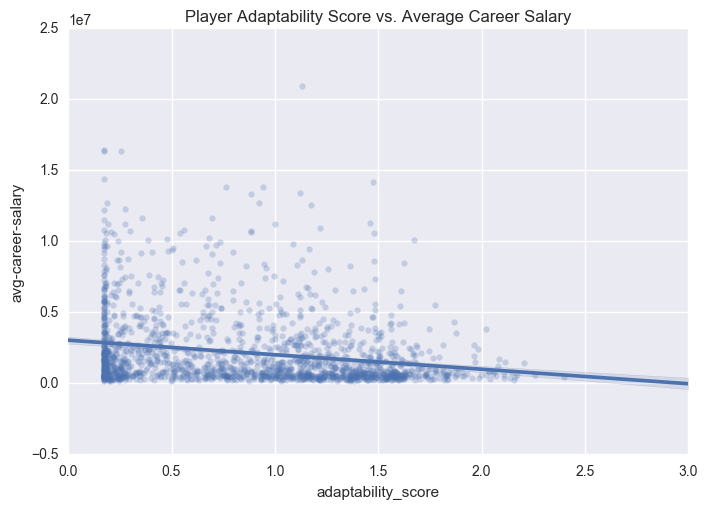

In [57]:
ax = sns.regplot(x='adaptability_score', y='avg-career-salary', data=salary_as, scatter_kws={'alpha':0.25})
ax.set_title('Player Adaptability Score vs. Average Career Salary')
plt.show()

In [58]:
salary_as[['adaptability_score','avg-career-salary']].corr()

,adaptability_score,avg-career-salary
adaptability_score,1.000000,-0.219501
avg-career-salary,-0.219501,1.000000


Finally, player adaptability score plotted agaist average salary shows an even stronger, though still weak, negative correlation. The fact that all three of these correlations being negative strikes me as interesting (more on this in the conclusion section).

##### Lifetime Batting Average vs. Player Adaptability Score
This plot is a 'curve-ball' that I'm throwing in here simply because it interests me. I wonder how lifetime batting average correlates to the measure for player adaptability score? It turns out, not at all!

In [59]:
# concatenate the batting_career table and the adaptability score column
adapt_batting = pd.concat([batting_career, players['adaptability_score']], axis=1)
adapt_batting.dropna(inplace=True)
adapt_batting

,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,lifetime_BA,adaptability_score
playerID,,,,,,,,,,,,,,,,,,,,
aaronha01,23,3298,12364,2174,3771,624,98,755,2297.0,240.0,73.0,1402,1383.0,293.0,32.0,21.0,121.0,328.0,0.3050,1.0550
aaronto01,7,437,944,102,216,42,6,13,94.0,9.0,8.0,86,145.0,3.0,0.0,9.0,6.0,36.0,0.2288,1.1727
abbotku01,11,702,2044,273,523,109,23,62,242.0,22.0,11.0,133,571.0,11.0,17.0,21.0,12.0,37.0,0.2559,1.3695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zobribe01,13,1337,4840,735,1287,296,38,145,643.0,111.0,43.0,700,839.0,32.0,26.0,23.0,55.0,97.0,0.2659,1.6274
zuninmi01,4,350,1125,117,219,43,2,50,133.0,1.0,4.0,75,404.0,1.0,31.0,8.0,8.0,23.0,0.1947,0.1716
zupcibo01,6,319,795,99,199,47,4,7,80.0,7.0,5.0,57,137.0,3.0,6.0,20.0,8.0,15.0,0.2503,1.6015


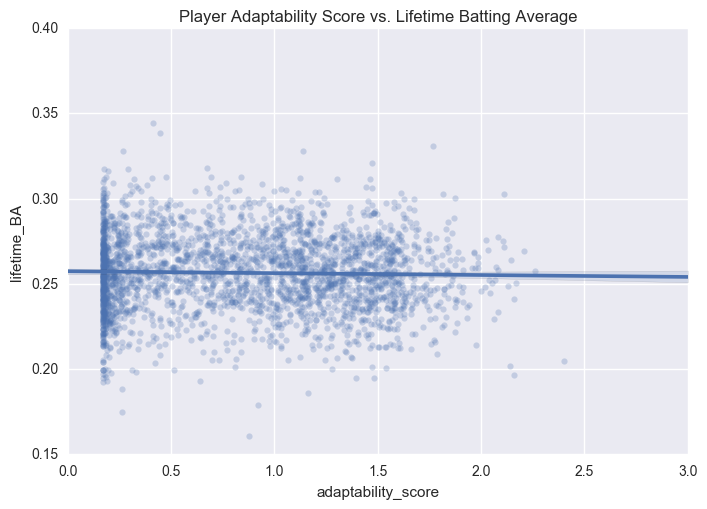

In [61]:
# plot the two variables against eachother
ax = sns.regplot(x='adaptability_score', y='lifetime_BA', data=adapt_batting, scatter_kws={'alpha':0.25})
ax.set_title('Player Adaptability Score vs. Lifetime Batting Average')
plt.show()

In [43]:
adapt_batting[['adaptability_score','lifetime_BA']].corr()

,adaptability_score,lifetime_BA
adaptability_score,1.00000,-0.02665
lifetime_BA,-0.02665,1.00000


This is a really clear sign that there is seemingly **NO** correlation between lifetime batting average and player adaptability in field positions. The only thing that comes to mind when trying to learn something here is that, I speculate, moving around in field positions (a higher player adaptability score) may have some influence on how eventually a player acheives a measure of success such as winning an award, going to an all-star game, or garnering a high salary, there is really only one 'position' in hitting, which is to hit and drive up that batting average! So I my intuition here is that there would not be any correlation behavior.

### CONCLUSION
The various notes throughout this report should suffice in pointing out the possible relationships between the measure of performance, which is lifetime batting average, and the measures of success - average awards, average All-Star appearances, and career average salary. 

Stepping back, what strikes me as interesting is that lifetime batting average seems to have a positive correlation behavior to the mesures of success while the player adaptability score has a negative relationship. I concede that the player adaptability score's negative relationship is weak but at least it's consistent. Players such as Hank Aaaron with very high measures of performance and success seem to affirm both the stronger and weaker correlations present in this analysis. Consistently positive relationships when looking at lifetime batting average's relationship to measure of success in combination with consistently negative relationships when looking at player adaptability is what interests me here. It would seem to justify further investigation, perhaps narrowing in further of segments of the plots and searching for some anechdotes by examining specific players. For now, this is just a tentative investigation that doesn't claim to make any definitive statements either way. 